In [7]:
# import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data

df = pd.read_pickle('Data.RQ4')

In [3]:
#filter event_type 'purchase' only, drop rows without a brand name, convert event_time to string ([year,month] format). This last operation helps when we will use [year,month] as a column name, because a column named with a Datetime Object is harder to access than a column whose name is a string 

purchases = df[df['event_type']=='purchase']
purchases = purchases.dropna(subset=['brand'])
purchases['brand'] = purchases['brand'].astype('string')
purchases['event_time'] = purchases.event_time.dt.to_period("M")
purchases['event_time'] = purchases.event_time.dt.strftime('%Y-%m')

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [17]:
# compute the average price of products, using an histogram to describe the result (simple version, assumes that the price of a product stays the same)
df['event_time'] = df.event_time.dt.normalize()

In [18]:
df_unique_products = df.drop_duplicates(subset=['product_id','event_time'])

In [19]:
df_unique_products = df_unique_products.groupby('product_id').price.mean().to_frame().reset_index().rename(columns = {'price': 'mean_price'})

In [20]:
df = df.drop_duplicates(subset=['product_id'])

In [21]:
df = pd.merge(df,df_unique_products, left_on=['product_id'], right_on=['product_id'])

In [22]:
df = df.groupby('brand').mean_price.mean()

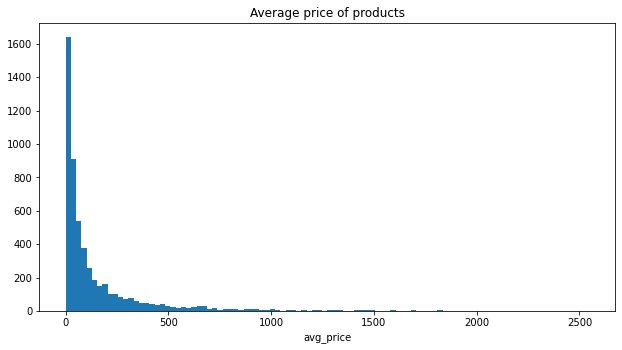

In [23]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(8)
ax = fig.add_axes([0,0,1,1])
ax.hist(df, bins= 100)
plt.title('Average price of products')
plt.xlabel('avg_price')
plt.show()

In [24]:
#calls a function that prompts the user to enter a brand name, returns a table

def my_funct(df, mode = 0):
    '''
    mode = 0 : takes a DataFrame, asks to input a brand and returns a table showing its profit for each month
   

    mode = 1 : takes a DataFrame, returns the 3 brands with the worst losses between two months
    '''
    if mode == 0:
        brand = input('Select a brand:\n')
        brand_df = df.loc[df['brand'] == brand]
        profit_df = brand_df.groupby('event_time')['price'].sum().reset_index()
        #profit_df = brand_df.groupby(by = [brand_df.event_time.dt.year, brand_df.event_time.dt.month])['price'].sum().rename_axis(['year', 'month']).reset_index()
        profit_df = profit_df.rename(columns={'price': 'profit'})
        return profit_df
    elif mode == 1:
        months = df.event_time.unique()
        profit_delta = pd.pivot_table(df, values='price', index=['brand'], columns=[df.event_time], aggfunc=np.sum).reset_index()
        profit_delta.fillna(0, inplace=True)
        total_df =[]
        for i in range(1,len(months)):
            temp_df = profit_delta
            temp_df['delta_num'] = temp_df[months[i]] - temp_df[months[i-1]]
            temp_df['delta_perc'] = temp_df['delta_num'] / temp_df[months[i-1]]
            temp_df.replace([np.inf], 1, inplace=True)
            temp_df.replace([np.nan], 0, inplace=True)
            temp_df = temp_df.sort_values(by=['delta_num','delta_perc'], ascending=True)[:3]
            temp_df= temp_df.assign(start_month = (months[i-1]))
            temp_df= temp_df.assign(end_month = (months[i]))
            total_df.append(temp_df)
        total_df = pd.concat(total_df, axis=0, ignore_index=True)
        total_df = total_df.sort_values(by=['delta_num','delta_perc'], ascending=True)
        total_df = total_df.drop_duplicates(subset=['brand'], keep = 'first')[:3]
        for index, row in total_df.iterrows():
            print('brand {0} lost {1:.2%} between {2} and {3}, for a value of {4:,}'.format(row['brand'], -1*row['delta_perc'],row['start_month'],row['end_month'],round(row['delta_num'],2)), end='\n')

In [5]:
my_funct(purchases, mode = 0)

Select a brand:
samsung


,event_time,profit
0,2019-10,46407532.0
1,2019-11,54869880.0
2,2019-12,71858808.0
3,2020-01,55786628.0
4,2020-02,74269248.0
5,2020-03,65440260.0
6,2020-04,56791600.0


In [25]:
my_funct(purchases, mode = 1)

brand apple lost 47.43% between 2020-03 and 2020-04, for a value of -67,027,280.0
brand samsung lost 22.37% between 2019-12 and 2020-01, for a value of -16,072,180.0
brand xiaomi lost 29.05% between 2020-02 and 2020-03, for a value of -5,142,528.0
